In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import wrds
WRDS_LOGIN = ''

db = wrds.Connection(wrds_username=WRDS_LOGIN)

Loading library list...
Done


# Google's At-the-money Options

For this investigation, we will analyze the implied volatility of options and evaluate Black-Scholes hedging for options on stocks issued by Google. We will only consider options that have the following properties:

1. At-the-money (moneyness is between $99\%$ and $101\%$)
2. Time-to-maturity is strictly between $21$ and $35$ calendar days.

   
## Retrieving Relevent Options

Before observing the information on stock options, we must find the relevant identifiers of the underlying securities issued by Google.

In [108]:
print(f'List of all tables in the wrdsapps_link_crsp_optionm library: {db.list_tables(library='wrdsapps_link_crsp_optionm')}')

List of all tables in the wrdsapps_link_crsp_optionm library: ['opcrsphist']


In [109]:
query = """
        SELECT *
        FROM wrdsapps_link_crsp_optionm.opcrsphist
        LIMIT 5
        """
db.raw_sql(query, date_cols=['sdate', 'exdedateate'])

,secid,sdate,edate,permno,score
0,5001.0,1996-01-02,1996-03-13,10074.0,1.0
1,5002.0,1996-01-01,1996-02-22,10154.0,1.0
2,5003.0,NaT,None,NaN,6.0
3,5004.0,1996-01-01,2000-01-27,80071.0,1.0
4,5005.0,1996-01-01,1997-08-12,85041.0,1.0


We want to match the `permno` for all Google securities with the `secid` of all of the options. 

In [111]:
google_permco = 45483

query = f"""
        SELECT DISTINCT wrdsapps_link_crsp_optionm.opcrsphist.secid,
        crsp.stocknames_v2.permno,
        wrdsapps_link_crsp_optionm.opcrsphist.sdate,
        wrdsapps_link_crsp_optionm.opcrsphist.edate
        FROM crsp.stocknames_v2
        JOIN
        wrdsapps_link_crsp_optionm.opcrsphist
        ON crsp.stocknames_v2.permno = wrdsapps_link_crsp_optionm.opcrsphist.permno
        WHERE crsp.stocknames_v2.permco = {google_permco}
        """
google_option_data_df = db.raw_sql(query)
google_option_data_df

,secid,permno,sdate,edate
0,121812.0,90319,2004-08-19,2024-12-31
1,203876.0,14542,2014-04-03,2024-12-31


The OptionMetrics security ID of the two relevant underlying securities that will be investigated are:
* `121812` - Class A (voting)
* `203876` - Class C (non-voting)

In [113]:
# will be helpful later
class_a = 121812
class_c = 203876

## Implied Volatility of At-the-money Options

Now that we have the security IDs of the two stocks, we can retrieve the relevant option data and clean it.

In [115]:
sec_ids = '121812, 203876'

In [116]:
%%time
year = 2022
query= f"""
        SELECT *
        FROM optionm.opprcd{year}
        WHERE secid in ({sec_ids})
        """
dl_2022 = db.raw_sql(query, date_cols=['date', 'exdate'])

CPU times: user 13 s, sys: 2.87 s, total: 15.9 s
Wall time: 59.2 s


In [117]:
%%time
year = 2023
query= f"""
        SELECT *
        FROM optionm.opprcd{year}
        WHERE secid in ({sec_ids})
        """
dl_2023 = db.raw_sql(query, date_cols=['date', 'exdate'])

CPU times: user 4.83 s, sys: 914 ms, total: 5.75 s
Wall time: 16 s


In [118]:
g_options = pd.concat([dl_2022, dl_2023])
g_options = g_options.reset_index(drop=True)

In [119]:
query = f"""
        SELECT * 
        FROM optionm.secprd
        WHERE secid in ({sec_ids})
        AND date >= '2021-12-31'
        """
GOOG = db.raw_sql(query, date_cols=['date'])

In [120]:
GOOG.tail()

,secid,date,low,high,close,volume,return,cfadj,open,cfret,shrout
833,203876.0,2023-08-25,128.040,131.400,130.69,20678096.0,0.002070,20.05491,130.1400,20.05491,12610000.0
834,203876.0,2023-08-28,130.850,133.240,131.79,16715467.0,0.008417,20.05491,132.0800,20.05491,12610000.0
835,203876.0,2023-08-29,132.980,137.295,135.49,30803265.0,0.028075,20.05491,132.9981,20.05491,12610000.0
836,203876.0,2023-08-30,135.021,137.250,136.93,21773356.0,0.010628,20.05491,135.5700,20.05491,12610000.0
837,203876.0,2023-08-31,136.820,138.400,137.35,28147850.0,0.003067,20.05491,137.0500,20.05491,12610000.0


It would appear that Option Metrics only provides data on stocks up until August 31 2023.

In [122]:
g_options.tail()

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix
2781249,203876.0,2023-08-31,GOOG 251219P75000,1,2025-12-19,2023-08-31,P,75000.0,1.91,3.2,...,-1.536992,152535280.0,1.0,0.0,100.0,0,None,None,None,None
2781250,203876.0,2023-08-31,GOOG 251219P80000,1,2025-12-19,2023-08-29,P,80000.0,1.89,5.0,...,-1.833900,152535281.0,1.0,0.0,100.0,0,None,None,None,None
2781251,203876.0,2023-08-31,GOOG 251219P85000,1,2025-12-19,2023-08-31,P,85000.0,2.68,7.0,...,-2.239982,152535282.0,1.0,0.0,100.0,0,None,None,None,None
2781252,203876.0,2023-08-31,GOOG 251219P90000,1,2025-12-19,2023-08-31,P,90000.0,4.90,6.0,...,-2.327705,152535283.0,1.0,0.0,100.0,0,None,None,None,None
2781253,203876.0,2023-08-31,GOOG 251219P95000,1,2025-12-19,2023-08-31,P,95000.0,4.00,6.3,...,-2.120587,152535284.0,1.0,0.0,100.0,0,None,None,None,None


It is the same for option data. Moving forward, we will continue to look at all option data for 2022, and all option data for 2023 up until August 31, 2023.

### Adjusting for Corporate Action

Prior to any option-specific cleaning, all relevant prices must be adjusted.
$$\text{Adjusted Value}_t = \frac{\text{Value}_t * \text{Adjustment Factor}_t}{\text{Adjustment Factor}_T}$$
where $T$ is the most recent date and $t\leq T$.

In [124]:
# most recent adjustment factor
last_adj = GOOG.reset_index().sort_values(by='date').groupby('secid')['cfadj'].last().to_frame()
last_adj = last_adj.rename(columns={'cfadj':'last_adj'})
GOOG = GOOG.set_index('secid').join(last_adj).reset_index()
# get google adjusted closing price
GOOG['adj_close'] = GOOG['close'] * GOOG['cfadj'] / GOOG['last_adj']

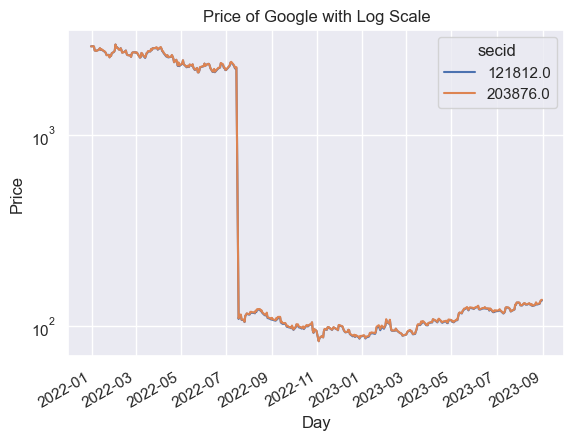

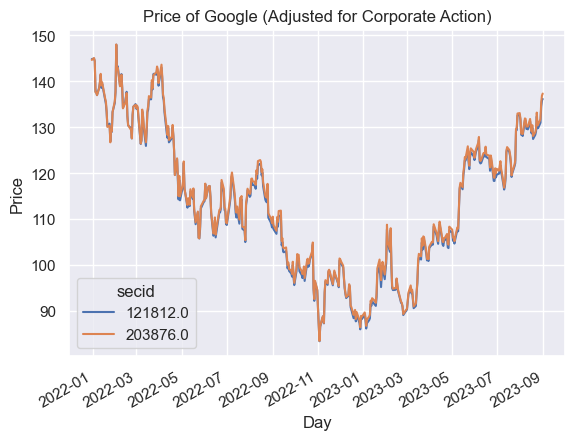

In [125]:
GOOG.pivot(index='date', columns='secid', values='close').plot(logy=True, title='Price of Google with Log Scale', ylabel='Price', xlabel='Day');
GOOG.pivot(index='date', columns='secid', values='adj_close').plot(title='Price of Google (Adjusted for Corporate Action)', ylabel='Price', xlabel='Day');

From observation, we can see that the prices of the voting and non-voting stocks have been correctly adjusted for splits and other factors.

In [127]:
# adjust option bid, ask, and strike to match
option_last_adj = g_options.sort_values(by='date').groupby('optionid')['cfadj'].last().to_frame()
option_last_adj = option_last_adj.rename(columns={'cfadj':'last_adj'})
g_options = g_options.set_index('optionid').join(option_last_adj).reset_index()
g_options['adj_strike_price'] = g_options['strike_price'] * g_options['cfadj'] / g_options['last_adj']
g_options['adj_bid'] = g_options['best_bid'] * g_options['cfadj'] / g_options['last_adj']
g_options['adj_offer'] = g_options['best_offer'] * g_options['cfadj'] / g_options['last_adj']

Now that all of the relavent values have been adjusted, we can merge the data.

In [129]:
GOOG = GOOG.set_index(['date', 'secid'])
g_options = g_options.set_index(['date', 'secid'])

In [130]:
g_options = g_options.merge(GOOG['adj_close'], how='left', right_index=True, left_on=['date', 'secid'])
g_options = g_options.reset_index()

### Building Option Specific Values
The following code is similar to the code used in lecture to build Black-Scholes style column names for each of the options. In the following code, we also implement general data filtering and investigation-specific data cleaning.

In [132]:
# code used in lecture to produce "B-S like columns"

g_options['K'] = g_options['adj_strike_price'] / 1000
# ^ optionmetrics convention, nothing super interesting under the hood, ensure to observe documentation
g_options['V0'] = (g_options['adj_bid'] + g_options['adj_offer']) / 2 # rough true price
g_options = g_options.rename(columns={'adj_close': 'S0'}) # B&S S0 price when pricing option
# < 1: out of the money
# = 1: on the money
# > 1: in the money
g_options['M0'] = g_options['S0'] / g_options['K']  # "moneyness"
# time left to T in years
g_options['tau'] = (g_options['exdate'] - g_options['date']).dt.days / 360

In [133]:
num_options = len(g_options['optionid'].unique())
print(f'Number of options before filtering: {round(num_options, 3)}')

Number of options before filtering: 50772


In [134]:

# filter by missing price data
bl = g_options['S0'].isnull() | g_options['V0'].isnull()
g_options = g_options[~bl]

# filter by missing delta
bl = g_options['delta'].isnull()
g_options = g_options[~bl]

# filter by open interest (contracts that exist)
bl = g_options['open_interest'].eq(0)
g_options = g_options[~bl]

# filter by volume
bl = g_options['volume'].eq(0)
g_options = g_options[~bl]

# filter out options with negative time value
# This is related to arbitrage
# here we assume r = 0
bl_c = (g_options['cp_flag'] == 'C') & (g_options['S0'] - g_options['K'] >= g_options['V0'])
bl_p = (g_options['cp_flag'] == 'P') & (g_options['K'] - g_options['S0'] >= g_options['V0'])
bl = bl_c | bl_p
g_options = g_options[~bl]

# filter out not at-the-money options
bl = ((g_options['M0'] > 1.01) | (g_options['M0'] < 0.99))
g_options = g_options[~bl]

# strictly between: (21, 35)
# filter out by maturity pt 1
# remove less than or equal to 21 days
bl = g_options['tau'].le(21/360)
g_options = g_options[~bl]

# filter out by maturity pt 2
# remove greater than or equal to 35 days
bl = g_options['tau'].ge(35/360)
g_options = g_options[~bl]

In [135]:
num_options = len(g_options['optionid'].unique())
print(f'Number of options after filtering: {num_options}')

Number of options after filtering: 2528


After cleaning and filtering, we have reduced the number of relavent options from approximitely $50,000$ to approximitely $2,500$. We will now observe the difference in implied volatility between Class A and Class C shares.

In [137]:
# group by security id, then group by the date, then find the mean of this
imp_vol_class_df = g_options.groupby(['secid', 'date'])['impl_volatility'].mean().to_frame().reset_index()

In [138]:
#pivot and clean up names
imp_vol_class_df = imp_vol_class_df.pivot(index='date', columns='secid', values='impl_volatility')
imp_vol_class_df = imp_vol_class_df.rename(columns={class_a:'Class A', class_c:'Class C'})
imp_vol_class_df.columns = imp_vol_class_df.columns.rename('Share Type')
imp_vol_class_df = imp_vol_class_df * 100 # percent

In [139]:
# make sure we cover the entire trading period
imp_vol_class_df[pd.isnull(imp_vol_class_df).any(axis=1)].head()

Share Type,Class A,Class C
date,,
2022-10-21,NaN,44.73650
2022-11-03,37.12505,NaN
2023-01-20,NaN,38.22535


We have found that during the cleaning process, there are some days where there are no valid options to derive an implied volatility from. To remedy this issue, we will use the prior days implied volatility to fill any missing values.

In [141]:
imp_vol_class_df = imp_vol_class_df.ffill()

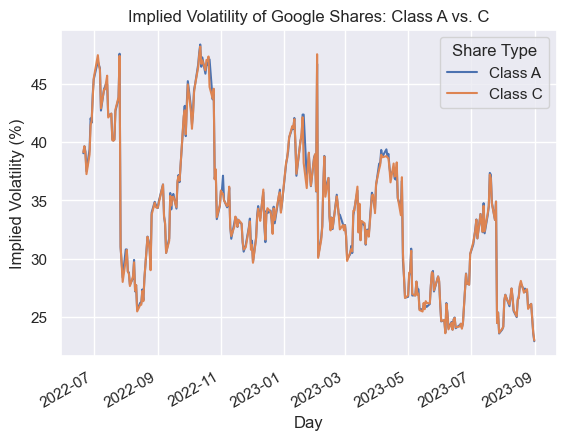

In [142]:
imp_vol_class_df.plot(title='Implied Volatility of Google Shares: Class A vs. C', ylabel='Implied Volatility (%)', xlabel='Day');

Above, the difference in the implied volatilities of the Class A and Class C shares can be seen. From inspection, it can be observed that the implied volatilities of options related to the two shares are very similar. There are two noticible dislocations where Class A shares increase in implied volatility away from Class C. These dislocations occur near the end of 2011, and around the middle of 2023.

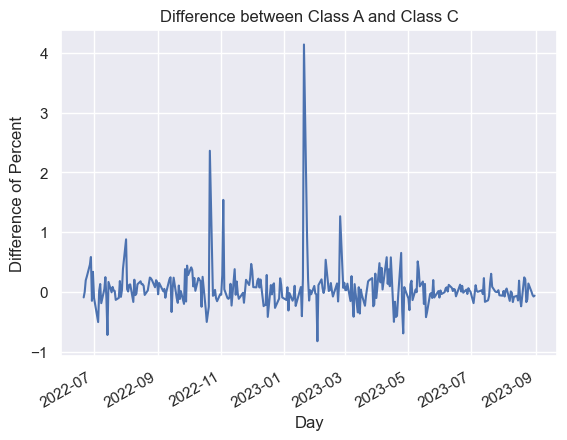

In [144]:
(imp_vol_class_df['Class A'] - imp_vol_class_df['Class C']).plot(title='Difference between Class A and Class C', ylabel='Difference of Percent', xlabel='Day');

When observing the difference in implied volatility between Class A and Class C shares, the days of large dislocation coincide with days with missing data. This suggests that the significant difference comes from the forward-filling cleaning process. It would appear that the only day on which implied volatility differs by more than $1\%$ is near the end of February 2023. Given the high liquidity of these options, such a small difference in implied volatility is understandable.

In [146]:
# group by option type, then group by the date, then find the mean of this
imp_vol_opt_df = g_options.groupby(['cp_flag', 'date'])['impl_volatility'].mean().to_frame().reset_index()
#pivot and clean up names
imp_vol_opt_df = imp_vol_opt_df.pivot(index='date', columns='cp_flag', values='impl_volatility')
imp_vol_opt_df = imp_vol_opt_df.rename(columns={'C':'Call', 'P':'Put'})
imp_vol_opt_df.columns = imp_vol_opt_df.columns.rename('Option Type')
imp_vol_opt_df = imp_vol_opt_df * 100 # percent

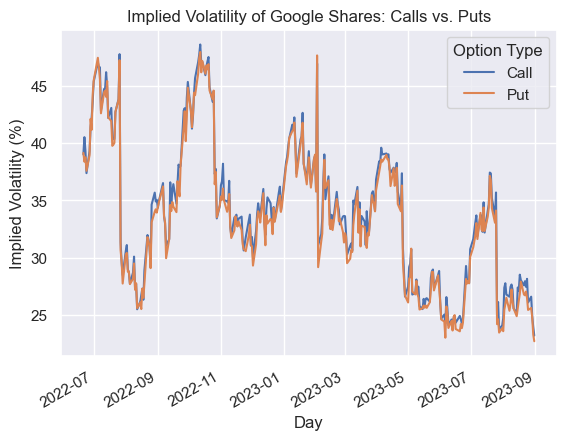

In [147]:
imp_vol_opt_df.plot(title='Implied Volatility of Google Shares: Calls vs. Puts', ylabel='Implied Volatility (%)', xlabel='Day');

We can see a visible difference between the implied volatility of call options and the options on all Google shares. It also appears that the most considerable dislocations occur when the implied volatility of call options increases relative to the implied volatility of put options. More considerable dislocations are understandable between the calls and puts compared to the different share classes, since calls and puts have significantly different functions. In contrast, Class A and Class C shares are incredibly similar.

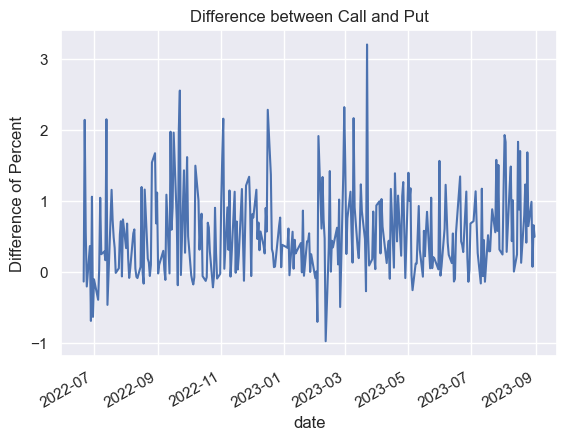

In [149]:
(imp_vol_opt_df['Call'] - imp_vol_opt_df['Put']).plot(title='Difference between Call and Put', ylabel='Difference of Percent');

Again, the difference between calls and puts is much more significant than the difference in share types. One possible cause for these dislocations is a different demand for calls compared to puts. We will investigate this possibility below.

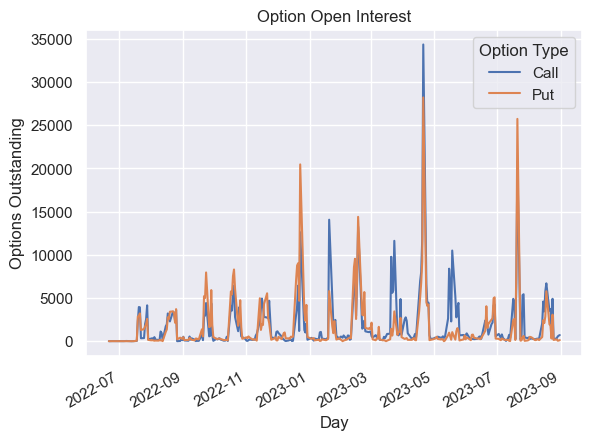

In [151]:
interest_opt_df = g_options.groupby(['cp_flag', 'date'])['open_interest'].mean().to_frame().reset_index()
#pivot and clean up names
interest_opt_df = interest_opt_df.pivot(index='date', columns='cp_flag', values='open_interest')
interest_opt_df = interest_opt_df.rename(columns={'C':'Call', 'P':'Put'})
interest_opt_df.columns = interest_opt_df.columns.rename('Option Type')

interest_opt_df.plot(title='Option Open Interest', xlabel='Day', ylabel='Options Outstanding');

As we hypothesised, there are many instances where demand for calls is significantly higher than demand for puts. Such a difference may be one source of difference in implied volatility between put and call options.

## Hedging a Short Position in an Option

We will now investigate the effectiveness of delta-hedging using the deltas provided by OptionMetrics. The trading strategy that we will conduct is shorting one option and hedging according to the provided delta. It is important to note that the delta of a short position is $-\Delta$ where $\Delta$ is the delta of a long position in that same option (i.e. to hedge a shorted position in $V_0$ with delta $\Delta$, purchase $\Delta S_0$). As well, we will consider the following hedging frequencies:

1. Daily.
2. Every second trading day.
3. Every fifth trading day.

Prior to analysing the hedging performance, some more cleaning is required on the set of options.

In [154]:
g_options.loc[g_options['optionid'] == 135993816][['date', 'optionid', 'best_bid']]

,date,optionid,best_bid
2047435,2022-12-22,135993816.0,3.9
2051494,2022-12-27,135993816.0,3.5


In [155]:
g_options.loc[(g_options['date'].between('2022-12-21', '2022-12-27')) & (g_options['optionid'] == 135993869)][['date', 'optionid', 'best_bid']]

,date,optionid,best_bid
2045570,2022-12-21,135993869.0,3.00
2049652,2022-12-23,135993869.0,3.25


During the cleaning process, we found that some options are not traded on consecutive days. An example can be seen above. To ensure there is no look-ahead bias with price of the underlying, or any bias from extrapolating historical option prices / greeks, we will remove all options that are not traded consecutively.

In [157]:
trading_days = g_options['date'].unique()

# The following deepseek promt was used to aid in the generation of this code:

#I have a pandas dataframe with trading days, option ids, and the price, I want
#to find all options that do not have consecutive trading days MAKE SURE IT CONSIDERS TRADING DAYS

def get_missing_days(group):
    option_dates = group['date'].unique()
    min_date, max_date = option_dates.min(), option_dates.max()
    expected_days = trading_days[(trading_days >= min_date) & (trading_days <= max_date)]
    missing = set(expected_days) - set(option_dates)
    if len(missing) < 1:
        missing = np.nan
    return pd.Series({'missing_days': missing})


# remove non-consecutive traded options
gap_details = g_options.groupby('optionid').apply(get_missing_days, include_groups=False)
gap_details = gap_details.isna()
gap_details = gap_details.rename(columns={'missing_days':'consecutive'})
g_options = g_options.merge(gap_details, on='optionid')
g_options = g_options.loc[g_options['consecutive'] == True]

In [158]:
# sort by time
g_options = g_options.sort_values('date')
# group by contract to get contract specific information
grouped = g_options.groupby('optionid')

# now that all of our options are consecutive, we do not need to worry about look ahead bias here!
g_options['S1'] = grouped['S0'].shift(-1) # doing this makes sure we done overlap between options, grouped must keep index
g_options['V1'] = grouped['V0'].shift(-1)

In [159]:
# filter by missing price data
bl = g_options['S1'].isnull() | g_options['V1'].isnull()
g_options = g_options[~bl]

In [160]:
num_options = len(g_options['optionid'].unique())
print(f'Number of options after filtering: {num_options}')

Number of options after filtering: 673


We now have a total of $673$ options to use in analysing the performance of the hedging strategies. For this analysis, we will observe and compare the daily PnL for the three hedging frequency strategies. We will assume that the risk-free rate is $0$. The strategy that we will conduct is as follows:

($t=0$)

1. Start with $\$0$ in bank account.
2. Short $1$ option with a value of $V_0$ (bank account is now $V_0$).
3. Hedge $V_0$ by purchasing $\Delta S_0$ (bank account is now $V_0 - \Delta S_0$)

($t=1$)

1. Close $\Delta S_1$, get $\Delta S_1$ cash (bank account is now $V_0 - \Delta S_0 + \Delta S_1$).
2. Close $-V_1$, pay $V_1$ cash (bank account is now $V_0 - \Delta S_0 + \Delta S_1 - V_1$).

This strategy leads to the following PnL:

$$
\begin{aligned}
\text{PnL} &= V_0 - \Delta S_0 + \Delta S_1 - V_1 \\
           &= V_0 - V_1 - \Delta S_0 + \Delta S_1\\
           &= \Delta (S_1 - S_0) - (V_1 - V_0) \\
\end{aligned}
$$


In [162]:
# deepseek was used to generate the following code block using the following prompt:

# "i have a pandas dataframe of multiple options with their deltas for each day,
# I want to adda column which is "5 day delta" which is a rolling block of the same delta for 5 days"


# Sort by option_id and date to ensure correct ordering
g_options = g_options.sort_values(['optionid', 'date'])

# Create a 5-day block indicator within each option group
g_options['5_day_block'] = g_options.groupby('optionid').cumcount() // 5

# Get the first delta value for each 2-day block within each option
g_options['5_day_delta'] = g_options.groupby(['optionid', '5_day_block'])['delta'].transform('first')

# Clean up (remove temporary column if needed)
g_options = g_options.drop(columns=['5_day_block'])



# do the same thing for 2-day block

# Sort by option_id and date to ensure correct ordering
g_options = g_options.sort_values(['optionid', 'date'])

# Create a 2-day block indicator within each option group
g_options['2_day_block'] = g_options.groupby('optionid').cumcount() // 2

# Get the first delta value for each 2-day block within each option
g_options['2_day_delta'] = g_options.groupby(['optionid', '2_day_block'])['delta'].transform('first')

# Clean up (remove temporary column if needed)
g_options = g_options.drop(columns=['2_day_block'])

In [163]:
# normalizing everything in terms of S0
# very similar code used in lecture notes
for feature in ['S0', 'S1', 'V0', 'V1']:
    g_options[feature+'_n'] = g_options[feature] / g_options['S0'] * 100

In [164]:
def pnl(df, delta):
    # end cash given that we short an option
    pnl = delta*(df['S1_n'] - df['S0_n']) - (df['V1_n'] - df['V0_n'])
    return pnl

In [165]:
# mse computation is from lecture notes

pnl_no_hedge_1_day = pnl(g_options, 0)
pnl_BS_1_day = pnl(g_options, g_options['delta'])

# compute MSE
mse_no_hedge_1_day = (pnl_no_hedge_1_day** 2).mean()
mse_BS_1_day = (pnl_BS_1_day** 2).mean()

reduction_1_day = 100 * (1-mse_BS_1_day/mse_no_hedge_1_day)

In [166]:
pnl_no_hedge_2_day = pnl(g_options, 0)
pnl_BS_2_day = pnl(g_options, g_options['2_day_delta'])

# compute MSE
mse_no_hedge_2_day = (pnl_no_hedge_2_day** 2).mean()
mse_BS_2_day = (pnl_BS_2_day** 2).mean()

reduction_2_day = 100 * (1-mse_BS_2_day/mse_no_hedge_2_day)

In [167]:
pnl_no_hedge_5_day = pnl(g_options, 0)
pnl_BS_5_day = pnl(g_options, g_options['5_day_delta'])

# compute MSE
mse_no_hedge_5_day = (pnl_no_hedge_5_day** 2).mean()
mse_BS_5_day = (pnl_BS_5_day** 2).mean()

reduction_5_day = 100 * (1-mse_BS_5_day/mse_no_hedge_5_day)

In [168]:
res = {
    'Hedging Frequency': [1,2,5],
    'M-S PnL Hedgeless':[mse_no_hedge_1_day,mse_no_hedge_2_day,mse_no_hedge_5_day],
    'M-S PnL Hedged': [mse_BS_1_day, mse_BS_2_day, mse_BS_5_day],
    'M-S PnL Reduction (%)': [reduction_1_day, reduction_2_day, reduction_5_day]
      }
pd.DataFrame(res).set_index('Hedging Frequency')

,M-S PnL Hedgeless,M-S PnL Hedged,M-S PnL Reduction (%)
Hedging Frequency,,,
1,0.138765,0.024797,82.130221
2,0.138765,0.025321,81.752856
5,0.138765,0.025580,81.566242


The results of the daily mean-squared PnL for the different hedging frequencies can be seen above. As can be seen, all three significantly reduce the mean-squared PnL by more than $81\%$. As would be expected, a slower hedging frequency led to a smaller reduction in the mean-squared PnL. Although that is true, it is important to note that all three hedging frequencies had a massive decrease in mean-squared PnL.

The mean-squared PnL reduction is lower than anticipated ($\approx 90\%$ for B-S daily rebalancing). A possible cause for this reduction in performance is the choice of observing hedging performance of at-the-money options only. Due to the 'S-shape' of the delta curve around the strike, at-the-money options have the highest delta sensitivity to price change (Gamma). This means that any change in the underlying price will have a more significant change in the delta that is necessary to hedge properly. Due to the somewhat low frequency of hedging, it is understandable that the daily hedging strategy does not have the theoretical mean-squared reduction of $90\%$. 

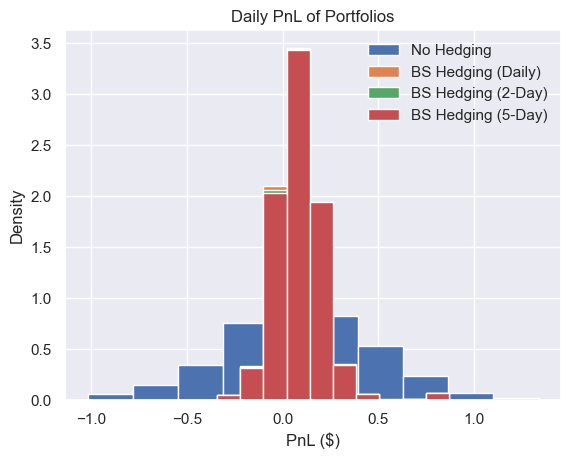

In [170]:
# overlapping histogram builds on lecture notes

ax= pnl_no_hedge_1_day.hist(bins=10, label='No Hedging', density=True)
pnl_BS_1_day.hist(bins=10, label='BS Hedging (Daily)', density=True)
pnl_BS_2_day.hist(bins=10, label='BS Hedging (2-Day)', density=True)
pnl_BS_5_day.hist(bins=10, label='BS Hedging (5-Day)', density=True)
ax.legend(frameon=False)
ax.set_xlabel('PnL ($)')
ax.set_ylabel('Density')
ax.set_title('Daily PnL of Portfolios');

Further, by observing the distributions of the Daily PnL for the four strategies, as the hedging frequency slows down, the distribution begins to flatten, and the high density of the mean around $0$ decreases. It can also be observed that daily hedging has the highest density around $0$, which is the target PnL of the hedging strategy. This result suggests that increasing hedging frequency can reduce the magnitude of daily PnL closer to $0$.

In [172]:
db.close()